In this notebook, I am exploring why the aigned environmental discourse word2vec models seem to show a cyclical trend in the amount of semantic change occurring over time.

In [221]:
import pandas as pd
import gensim
import numpy as np
import sklearn.metrics.pairwise #For cosine similarity
import plotly.express as px
from gensim import corpora, models
import copy
import matplotlib.pyplot as plt

#### Read in data, create work embeddings, print vocabulary sizes
 - Question: How can the vocab sizes here be in the 15,000 range, when I reported previously that the vocab size for the entire dataset (before reduction) was closer to 200,000?

In [2]:
dfs = []
for i in range(5,22):
    j = str(i)
    k = (2 - len(j)) * '0' + j
    dfs.append(pd.read_pickle('../Data/Environmental Discourse/sent_processing/env_processed_sent_{}.pkl'.format(k)))

In [84]:
we_a = []
for df in dfs:
    we_a.append(gensim.models.word2vec.Word2Vec(df.sents.sum(), sg=1))

In [85]:
for i, w in enumerate(we_a):
    w.save("../Data/Environmental Discourse/Word-Embeddings/w2v_raw_{}".format(i+2005))

In [202]:
we_b = []
for i in range(2005, 2022):
    we_b.append(gensim.models.word2vec.Word2Vec.load(
        '../Data/Environmental Discourse/Word-Embeddings/w2v_raw_{}'.format(i)
    ))

In [203]:
vocab_sizes = [len(e.wv.index_to_key) for e in we_b]

In [204]:
vocab_sizes

[15674,
 18258,
 20541,
 20519,
 22688,
 24743,
 23656,
 23096,
 21252,
 19358,
 19922,
 17845,
 16737,
 15900,
 16735,
 18845,
 19454]

#### Understand the alignment process step-by-step from 2005 to 2006

In [128]:
np.all(we_b[0].wv[0] == we_a[0].wv[0])

True

In [113]:
m5 = we_b[0]
m6 = we_b[1]

# Step 1: Get vocabularies in sets
vocab_05 = set(m5.wv.index_to_key)
vocab_06 = set(m6.wv.index_to_key)

print(len(vocab_05))
print(len(vocab_06))

15674
18258


In [114]:
# Step 2: Get common vocabulary:
common_vocab = vocab_05 & vocab_06

print(len(common_vocab))

13104


In [116]:
# Step 3: Check if vocab is identical
if not vocab_05 - common_vocab and not vocab_06 - common_vocab:
    print("Identical vocab")

print(len(vocab_05 - common_vocab))
print(len(vocab_06 - common_vocab))

2570
5154


In [117]:
# Step 4: Sort by frequency across both corpora
common_vocab = list(common_vocab)
common_vocab.sort(key=lambda w: m5.wv.get_vecattr(w, "count") + m6.wv.get_vecattr(w, "count"), reverse=True)

print(common_vocab[:20])

['oil', 'energy', 'world', 'new', 'people', 'said', 'years', 'like', 'environmental', 'year', 'time', '$', 'gas', 'prices', 'u.s', 'says', 'way', 'use', 'fuel', 'percent']


In [119]:
# Step 5: Create an index list for all the common vocab words in the 2005 corpus
indices = [m5.wv.key_to_index[w] for w in common_vocab]

# Step 6: Replace vectors attribute with only the vectors for the common vocab
old_arr = m5.wv.vectors
new_arr = np.array([old_arr[index] for index in indices])
m5.wv.vectors = new_arr

# Step 7: Replace key_to_index and index_to_key attributes with common vocab
new_key_to_index = {}
new_index_to_key = []
for new_index, key in enumerate(common_vocab):
    new_key_to_index[key] = new_index
    new_index_to_key.append(key)
m5.wv.key_to_index = new_key_to_index
m5.wv.index_to_key = new_index_to_key

In [121]:
# Step 8: Repeat steps 5-7 for the 2006 corpus
indices = [m6.wv.key_to_index[w] for w in common_vocab]

old_arr = m6.wv.vectors
new_arr = np.array([old_arr[index] for index in indices])
m6.wv.vectors = new_arr

new_key_to_index = {}
new_index_to_key = []
for new_index, key in enumerate(common_vocab):
    new_key_to_index[key] = new_index
    new_index_to_key.append(key)
m6.wv.key_to_index = new_key_to_index
m6.wv.index_to_key = new_index_to_key

In [122]:
# Step 9: Update the normed vectors, save them to their own objects
m5.wv.fill_norms(force=True)
m6.wv.fill_norms(force=True)

m5_normed_vectors = m5.wv.get_normed_vectors()
m6_normed_vectors = m6.wv.get_normed_vectors()

In [124]:
# Step 10: Get the dot-product
m = m6_normed_vectors.T.dot(m5_normed_vectors) 

print(m.shape)

(100, 100)


In [125]:
# Step 11: Singular value decomposition of the dot-product
u, _, v = np.linalg.svd(m)

print(u.shape)
print(v.shape)

(100, 100)
(100, 100)


In [126]:
# Step 12: Dot product the outputs of SVD
ortho = u.dot(v) 

print(ortho.shape)

(100, 100)


In [127]:
# Step 13: Replace 2006 vectors with aligned vectors, fill norms again
m6.wv.vectors = (m6.wv.vectors).dot(ortho)
m6.wv.fill_norms(force=True)

#### Reproduce the cyclical pattern observed in previous analysis

In [205]:
aligned_pairs = []
for a, b in zip(we_b[:-1], we_b[1:]):
    aligned_pairs.append(align(a, b))

In [153]:
lda = models.ldamodel.LdaModel.load('../Data/Environmental Discourse/Full-TMs/Models/tm_09')

topwords = []
for topicNum in range(lda.num_topics):
    topwords += [w for w, p in lda.show_topic(topicNum, 20)]
    
topwords = list(set(topwords))

In [215]:
divs = pd.DataFrame(index=range(2006,2022))

unfound_words = [[] for _ in range(len(aligned_pairs))]
for w in topwords:
    d = []
    for i, (a, b) in enumerate(aligned_pairs):
        try:
            d.append(findDivergence(w, a, b))
        except KeyError:
            d.append(np.nan)
            unfound_words[i].append(w)
            
    divs[w] = d
    divs = divs.copy()

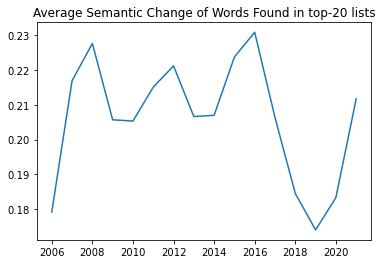

In [227]:
plt.plot(divs.mean(axis=1))
plt.title("Average Semantic Change of Words Found in top-20 lists");

In [234]:
divs = pd.DataFrame(index=range(2006,2022))
means = []

for i, (a, b) in enumerate(aligned_pairs):
    words = a.wv.index_to_key
    d = []
    for w in words:
        try:
            d.append(findDivergence(w, a, b))
        except KeyError:
            print("error")
            d.append(np.nan)
            
    means.append(sum(d)/len(d))
divs['avg'] = means

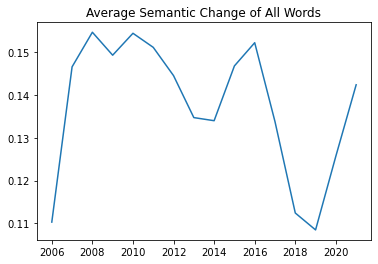

In [237]:
plt.plot(divs)
plt.title("Average Semantic Change of All Words");

In [239]:
sets = []
for a, b in aligned_pairs:
    sets.append(set(a.wv.index_to_key))

In [250]:
common_vocab = list(sets[0] & sets[1]  & sets[2]  & sets[3]  & sets[4]  & sets[5]  & sets[6]  & sets[7]  & sets[8] &
    sets[9] & sets[10] & sets[11] & sets[12] & sets[13] & sets[14] & sets[15])

In [251]:
divs = pd.DataFrame(index=range(2006,2022))
means = []

for i, (a, b) in enumerate(aligned_pairs):
    d = []
    for w in common_vocab:
        try:
            d.append(findDivergence(w, a, b))
        except KeyError:
            print("error")
            d.append(np.nan)
            
    means.append(sum(d)/len(d))
divs['avg'] = means

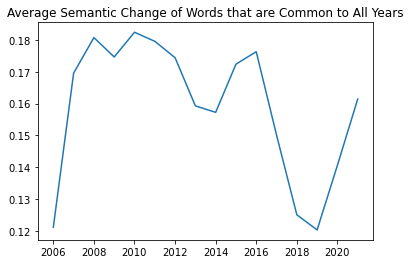

In [252]:
plt.plot(divs)
plt.title("Average Semantic Change of Words that are Common to All Years");

In [206]:
for a, b in aligned_pairs[:1]: 
    print(len(a.wv.index_to_key), len(b.wv.index_to_key))

13104 13104
15040 15040
16015 16015
16848 16848
18432 18432
18746 18746
18393 18393
17317 17317
15741 15741
15134 15134
14472 14472
13272 13272
12725 12725
12781 12781
13911 13911
14805 14805


#### Question: Vocabulary Size
As shown below, the words captured by the dictionary but not captured by the word2vec models are mostly misspellings or tokenization failures

In [267]:
all_words = []
for em in we_b:
    #print(len(em.wv.index_to_key))
    all_words += em.wv.index_to_key

print(len(set(all_words)))

51003


In [268]:
env = pd.concat(dfs)

In [271]:
dictionary = corpora.Dictionary([i for j in env.sents for i in j])

In [272]:
len(dictionary.token2id)

249005

In [288]:
print(list(set(dictionary.token2id.keys()) - set(all_words))[:30])

['miasole', 'comptrollerprepare', 'energycross', 'blueberrry', 'telegrams', 'fieldsstarted', 'crespin', 'provisioner', 'zinner', 'audobon', 'www.nrdc.org', 'olwen', 'variolation', 'lindstedt', 'corley', 'iconoclasts', 'kigbara', 'zedong', 'stryker', 'salwood', 'gas-\xadguzzling', 'ocupante', 'peloponnese', 'eod', 'heiress', 'gas—187', 'premeditation', 'kimberlyfaye', 'schnauzergovernment', 'outre']


#### How have certain words moved?

In [294]:
we_b[0].wv.most_similar('justice')

[('organizing', 0.8444629907608032),
 ('declaration', 0.8322417140007019),
 ('advocacy', 0.8202457427978516),
 ('public_health', 0.8170891404151917),
 ('constitutional', 0.8154703974723816),
 ('extremists', 0.8129733204841614),
 ('criticized', 0.8117318749427795),
 ('judges', 0.8105897307395935),
 ('fiat', 0.809802770614624),
 ('peace', 0.8096796870231628)]

In [295]:
we_b[-1].wv.most_similar('justice')

[('ej', 0.7341620326042175),
 ('environmental', 0.7330613732337952),
 ('equity', 0.7202240824699402),
 ('inclusion', 0.7198963165283203),
 ('racial', 0.7192055583000183),
 ('advocates', 0.7062668204307556),
 ('equality', 0.6881920695304871),
 ('campaigned', 0.685377836227417),
 ('immigration', 0.6757542490959167),
 ('ministries', 0.6719401478767395)]

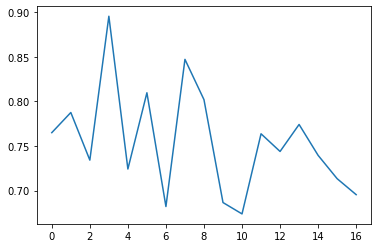

In [293]:
extraction_justice = [we.wv.distance('extraction', 'justice') for we in we_b]
plt.plot(extraction_justice)

In [54]:
for word in we_06.wv.key_to_index.keys():
    if sum(we_06.wv[word] - a_06.wv[word]) != 0:
        print(word)

In [259]:
def findDivergence(word, embedding1, embedding2):
    
    div = 1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embedding1.wv[word], axis = 0), 
                                                         np.expand_dims(embedding2.wv[word], axis = 0))[0,0]
    return div

def findMostDivergent(embedding1, embedding2):
    words = list(embedding1.wv.index_to_key) + list(embedding2.wv.index_to_key)
    words = set(words)
    #print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embedding1, embedding2)) for w in words], key = lambda x: x[1], reverse=True)

In [201]:
def align(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed = copy.deepcopy(base_embed)
    other_embed = copy.deepcopy(other_embed)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    
    # get the (normalized) embedding matrices
    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)
    other_embed.wv.fill_norms(force=True)
     
    
    return base_embed, other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        print("What?")
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        #print("starting")
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        #print(indices)
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        #print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)